In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['agg.path.chunksize'] = 1000000

In [88]:
df = pd.read_csv('db-cargo-delays-2016.csv', delimiter=';')
df.head()

,BST_NR_8,Land,PROD_DATUM,Zugfahrten,Verspaetungsminuten
0,80197079,DEUTSCHLAND,16.03.2016 00:00,39,49
1,80160168,DEUTSCHLAND,01.11.2016 00:00,12,0
2,80105122,DEUTSCHLAND,30.04.2016 00:00,16,2
3,80190793,DEUTSCHLAND,31.07.2016 00:00,14,0
4,80231464,DEUTSCHLAND,04.05.2016 00:00,10,2


In [89]:
df[df['Land'] == 'DEUTSCHLAND'].head()

,BST_NR_8,Land,PROD_DATUM,Zugfahrten,Verspaetungsminuten
0,80197079,DEUTSCHLAND,16.03.2016 00:00,39,49
1,80160168,DEUTSCHLAND,01.11.2016 00:00,12,0
2,80105122,DEUTSCHLAND,30.04.2016 00:00,16,2
3,80190793,DEUTSCHLAND,31.07.2016 00:00,14,0
4,80231464,DEUTSCHLAND,04.05.2016 00:00,10,2


In [90]:
df2 = df[df['Land'] == 'DEUTSCHLAND']
df2 = df2.reset_index(drop=True)
df2.to_csv('db-cargo-delays-2016-deutschland.csv', index=False)

In [91]:
len(df), len(df2), len(df) - len(df2)

(778955, 771621, 7334)

In [92]:
df2['PROD_DATUM'] = pd.to_datetime(df2['PROD_DATUM'])
df2.head()

,BST_NR_8,Land,PROD_DATUM,Zugfahrten,Verspaetungsminuten
0,80197079,DEUTSCHLAND,2016-03-16,39,49
1,80160168,DEUTSCHLAND,2016-01-11,12,0
2,80105122,DEUTSCHLAND,2016-04-30,16,2
3,80190793,DEUTSCHLAND,2016-07-31,14,0
4,80231464,DEUTSCHLAND,2016-04-05,10,2


In [95]:
df2['dayofweek'] = df2['PROD_DATUM'].dt.dayofweek + 1
df2['weekofyear'] = df2['PROD_DATUM'].dt.weekofyear
df2['month'] = df2['PROD_DATUM'].dt.month
df2.head()

F:\Documents\GitProjects\hs-dl-ws-2021\autogluon\autogluon-venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,BST_NR_8,Land,PROD_DATUM,Zugfahrten,Verspaetungsminuten,dayofweek,weekofyear,month
0,80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3
1,80160168,DEUTSCHLAND,2016-01-11,12,0,1,2,1
2,80105122,DEUTSCHLAND,2016-04-30,16,2,6,17,4
3,80190793,DEUTSCHLAND,2016-07-31,14,0,7,30,7
4,80231464,DEUTSCHLAND,2016-04-05,10,2,2,14,4


In [96]:
df2 = df2.reset_index(drop=True)
df2.to_csv('db-cargo-delays-2016-deutschland.csv', index=False)

In [116]:
groups = df2[['Zugfahrten', 'Verspaetungsminuten', 'month']].groupby(['month'])
groups

In [117]:
groups.groups.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

No handles with labels found to put in legend.


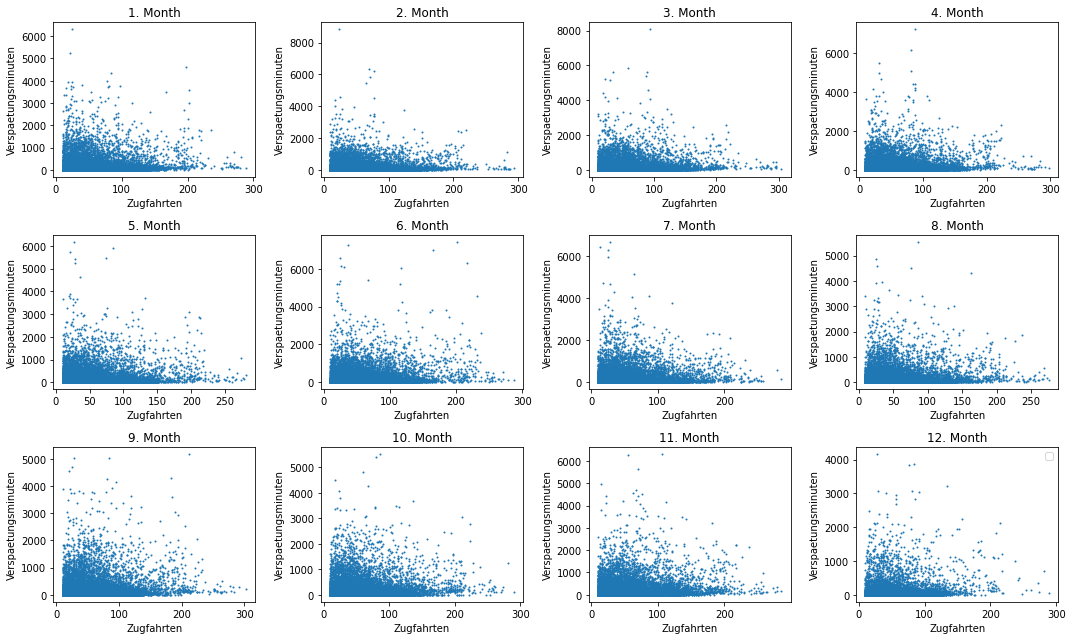

In [164]:
fig, axs = plt.subplots(3, 4, figsize=(15, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# axs = axs.ravel()
targets = zip(groups.groups.keys(), axs.flatten())

for i, (key, ax) in enumerate(targets):
    gr = groups.get_group(i+1)
    ax.scatter(gr['Zugfahrten'], gr['Verspaetungsminuten'], s=1)
    ax.set_title('%d. Month' % key)
    ax.set_xlabel('Zugfahrten')
    ax.set_ylabel('Verspaetungsminuten')

fig.tight_layout()
ax.legend()
plt.show()

No handles with labels found to put in legend.


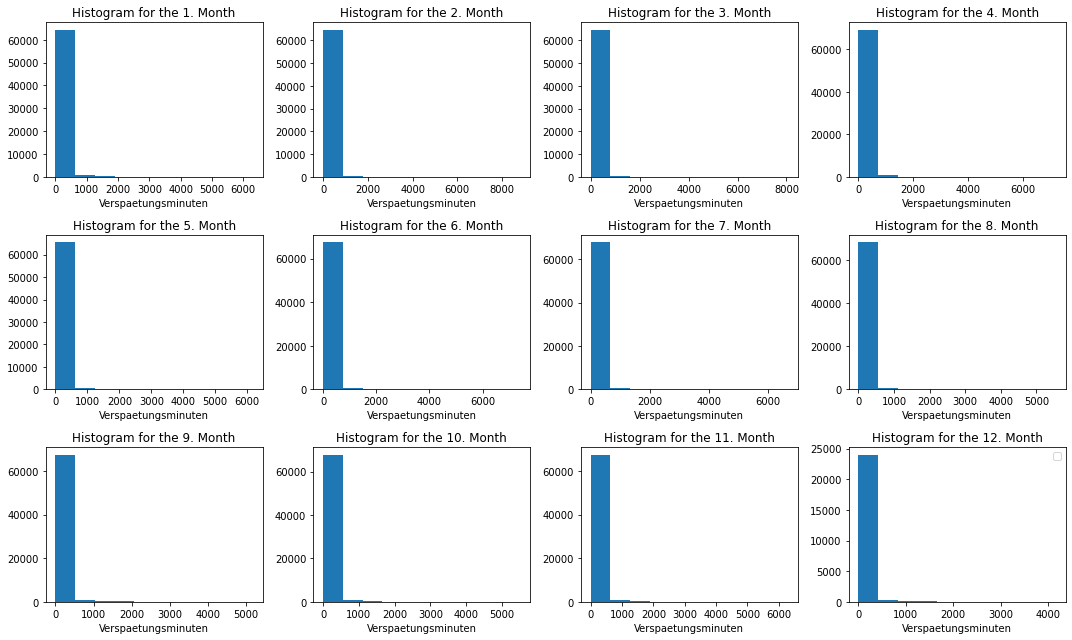

In [172]:
fig, axs = plt.subplots(3, 4, figsize=(15, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# axs = axs.ravel()
targets = zip(groups.groups.keys(), axs.flatten())

for i, (key, ax) in enumerate(targets):
    # gr = groups.get_group(i+1)
    ax.hist(groups.get_group(i+1)['Verspaetungsminuten'])
    ax.set_title('Histogram for the %d. Month' % key)
    ax.set_xlabel('Verspaetungsminuten')
    # ax.set_ylabel('Verspaetungsminuten')

fig.tight_layout()
ax.legend()
plt.show()